In [110]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pathlib
from PIL import Image

%matplotlib inline

In [111]:
from keras.models import Sequential
from keras.layers import Flatten, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Cat-Dog Classification
Here we are going to use LeNet architecture which is a very simple CNN architecture consisting of few convolution layers. This network is easy to train for learning purpose. However we will use advanced architectuer in later courses.  

LeNet architecture is as:  
![LeNet-5](./lenet-5.png)

Instead of using Dense Layers for classifier network, we are going to use FCNN as described below (after few cells).

## Load Data
We load data directly from the directory in the machine.

In [112]:
TRAIN_DIR = "/home/paradox/data/cat-dog/train"
VAL_DIR = "/home/paradox/data/cat-dog/val"

In [113]:
# image dimensions
WIDTH = 128
HEIGHT = 128
BATCH_SIZE = 64

## Keras Image Data Generator
This is a simple module that generates batches of data from the directory.  
Suppose we have some classes: **class-1**, **class-2**, etc., the directory structure is as follows:
```
|--dir_type/
    |--class-1
        |--image1
        |--image2
        |--...
    |--class-2
        |--image1
        |--image2
```

Where:  
```bash
dir_type => train/val/test
class-i => directory for class likecat/dog or any other  where images reside

The name of class directory is used by Keras as class label for training/prediction.
```

This image data generator also provides some preprocessing and simple augmentation of image (rotation, flipping, etc) more efficient training.

In [114]:
datagen = ImageDataGenerator(rescale=1./255)

## Create Train Generator
We generate batches of data from **train/** directory using this generator. The directory is as:  
```
|--train/
    |--cat
        |--image1
        |--image2
        |--...
    |--dog
        |--image1
        |--image2
```

In [115]:
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                             target_size = (WIDTH, HEIGHT),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Found 11967 images belonging to 3 classes.


## Visualize

In [116]:
train_files = train_generator.filenames

bg/SSDB00660.jpg
/home/paradox/data/cat-dog/train/bg/SSDB00660.jpg


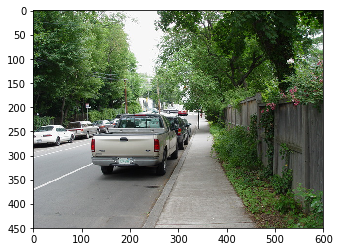

In [117]:
random_file = random.choice(train_files)
print(random_file)
random_file = TRAIN_DIR + '/' + random_file
print(random_file)
random_image = load_img(random_file)
plt.imshow(random_image)

## Create Validation Generator
We generate batches of data from **val/** directory using this generator. The directory is as:  
```
|--val/
    |--cat
        |--image1
        |--image2
        |--...
    |--dog
        |--image1
        |--image2
```

In [118]:
val_generator = datagen.flow_from_directory(VAL_DIR,
                                             target_size = (WIDTH, HEIGHT),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Found 2000 images belonging to 3 classes.


## Create Fully Convolutional Neural Network Model
Here, we build our own [FCNN](http://www.micc.unifi.it/bagdanov/pdfs/FCN-presentation.pdf) model on top of LeNet.  
We discard all the dense layers and replace them with equivalent Conv layers that give output of same shape.  
So, the output layer will have a feature map equal to **number of classess**. Hence, we view the output (1, 1, c) 
along depth-wise to get the probability of corresponding class.
  
Instead of using Dense Layers, we are going to use Fully Convolutional Networks. So, we do **1x1** convolution.  
The layers before using (1,1) filters are same as LeNet.  

#### LeNet
First let's look into LeNet with dense layers

In [10]:
def create_lenet_model(width, height, channels, num_class):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), input_shape=(width, height, channels)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    
    model.add(Dense(num_class))
    model.add(Activation('softmax'))
    
    return model
create_lenet_model(WIDTH, HEIGHT, 3, 3).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

#### Remove Classifier Dense Network with Conv Layers to create FCNN

In [11]:
def create_fcnn_model(width, height, channels, num_class):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), input_shape=(width, height, channels)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=100, kernel_size=(7, 7), strides=(1, 1)))
    
    model.add(Conv2D(filters=num_class, kernel_size=(1, 1), strides=(1, 1)))
    model.add(Activation('softmax'))
    
    return model

In [12]:
model = create_fcnn_model(WIDTH, HEIGHT, channels=3, num_class=3)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        2432      
_________________________________________________________________
activation_5 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 100)         313700    
__________

## Add Optimizer

In [14]:
from keras.optimizers import RMSprop, Adam

In [15]:
optimizer = Adam(lr=0.001)

In [16]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train Model
Here we are going to use **fit_generator** method instead of **fit** because we haven't loaded the training/val/test data yet. These data are generated by **ImageDataGenerator** at run time.

In [119]:
TRAIN_STEPS = train_generator.samples // train_generator.batch_size
VAL_STEPS = val_generator.samples // val_generator.batch_size
EPOCH = 20
TRAIN_STEPS, VAL_STEPS

(186, 31)

In [303]:
i = 0
for (X_train, Y_train) in train_generator:
    print("Step {} of {}".format(i, TRAIN_STEPS))
    Y_train = Y_train.reshape(BATCH_SIZE, 1, 1, 3)
    model.fit(
        X_train, Y_train,
        epochs = EPOCH, 
        batch_size = BATCH_SIZE,
        validation_split=0.1,
        verbose = 2
    )
    i += 1

In [ ]:
# history = model.fit_generator(
#     train_generator,
#     epochs=EPOCH,
#     steps_per_epoch=TRAIN_STEPS,
#     validation_data=val_generator,
#     validation_steps=VAL_STEPS,
#     verbose=1
# )

## Save Models
Instead of doing this, we can use **ModelCheckpoint** callback that saves the best model during trianing in real time.

In [122]:
# model.save_weights('models/catdog-fcn-3class5.h5')

## Load Weights

In [123]:
# model.load_weights('models/catdog-fcn.h5')

## Test Model
Here we are going to load a test image to seem model's prediction.

In [124]:
testfiles = val_generator.filenames
testfiles[:5]

['cat/cat.4001.jpg',
 'cat/cat.4002.jpg',
 'cat/cat.4003.jpg',
 'cat/cat.4004.jpg',
 'cat/cat.4005.jpg']

cat/cat.4087.jpg
/home/paradox/data/cat-dog/val/cat/cat.4087.jpg


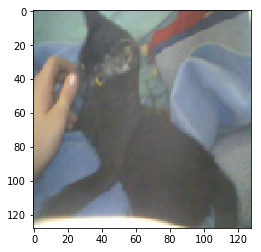

In [140]:
filename = random.choice(testfiles)
print(filename)
filename = VAL_DIR + '/' + filename
print(filename)
# img = load_img(filename, target_size=(WIDTH, HEIGHT))
img = load_img(filename)
img = img.resize((WIDTH, HEIGHT),Image.BICUBIC)
plt.imshow(img)

In [141]:
img = np.array(img) / 255

In [142]:
img.shape

(128, 128, 3)

In [143]:
# either expand dims
#img = np.expand_dims(img, axis=0)

# or insert img into a list
img = np.array([img])
img.shape

(1, 128, 128, 3)

In [144]:
predictions = model.predict(img)
predictions.shape, predictions

((1, 1, 1, 3),
 array([[[[0.03720947, 0.9336334 , 0.02915712]]]], dtype=float32))

In [145]:
train_generator.class_indices

{'bg': 0, 'cat': 1, 'dog': 2}

In [146]:
# predict class
model.predict_classes(img)

array([[[1]]])

# Object Localization
Create Another ConvNN that takes 256x256 image but all the kernels are same.  
Final output will be (9, 9, 2) instead of (1, 1, 2) in the training model.  
This (9, 9) gird will be used to determine the location of the cat/dog in the image.  
  
This is equivalent to using sliding window method, each slice taken as input to original model. So, we have to slide 
9x9 times i.e. 81 times and do 81 predictions for each slice. This is very inefficient since CNN is 
computation intensive.  
Hence, doing a direct CNN on 256x256 is far more efficient since it predicts all the 81 slices in single forward pass.

In [147]:
TEST_WIDHT, TEST_HEIGHT = 512, 512

In [148]:
def create_localization_model(width, height, channels, num_class):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), input_shape=(width, height, channels)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=100, kernel_size=(7, 7), strides=(1, 1)))
    
    model.add(Conv2D(filters=num_class, kernel_size=(1, 1), strides=(1, 1)))
    model.add(Activation('softmax'))
    
    return model

In [149]:
model_localization = create_localization_model(TEST_WIDHT, TEST_HEIGHT, 3, 3)

In [150]:
model_localization.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 32)      2432      
_________________________________________________________________
activation_11 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 62, 62, 64)        51264     
_________________________________________________________________
activation_12 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 100)       313700    
__________

#### Load Kernel Weights
Since we are using same filters/kernels, we load the corresponding weights.

In [151]:
kernel1 = model.layers[0].get_weights()
kernel2 = model.layers[3].get_weights()
kernel3 = model.layers[6].get_weights()
kernel4 = model.layers[7].get_weights()

model_localization.layers[0].set_weights(kernel1)
model_localization.layers[3].set_weights(kernel2)
model_localization.layers[6].set_weights(kernel3)
model_localization.layers[7].set_weights(kernel4)

### Load Test Image

In [190]:
import glob
import random

In [238]:
files = glob.glob('/home/paradox/data/cat-dog/test/cat/*')
# files = val_generator.filenames
files

['/home/paradox/data/cat-dog/test/cat/cat-5.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-6.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-7.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-4.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-13.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-9.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-14.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-12.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-3.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-2.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-1.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-8.jpg',
 '/home/paradox/data/cat-dog/test/cat/cat-10.jpeg']

/home/paradox/data/cat-dog/test/cat/cat-12.jpg


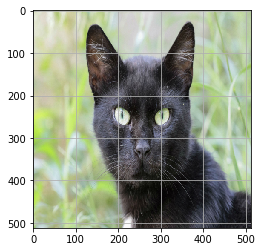

In [294]:
# path = VAL_DIR + '/' + random.choice(files)
path = random.choice(files)
print(path)
# testimg = load_img(path, target_size=(256, 256))
testimg = load_img(path)
testimg = testimg.resize((TEST_WIDHT, TEST_HEIGHT),Image.BICUBIC)
plt.imshow(testimg)
plt.grid(ls='solid')

#### Preprocess 
We have to do some preprocessing, since the trianing was done on a rescaled image where each pixel was in the range 0-1.  
Also, we have to expand dimension to convert into the input format shape of (n, 256, 256, 3)

In [295]:
# rescale
testimg = np.array(testimg) / 255
testimg.shape

(512, 512, 3)

In [296]:
# reshape
testimg = np.array([testimg])
testimg.shape

(1, 512, 512, 3)

#### Predict

In [297]:
predictions = model_localization.predict(testimg)
predictions.shape

(1, 25, 25, 3)

In [298]:
# since we are only predicting for single image, we can just take prediction from first index
predictions = predictions[0]
predictions.shape

(25, 25, 3)

In [299]:
# get grid size
n = predictions.shape[0]
n

25

In [300]:
train_generator.class_indices

{'bg': 0, 'cat': 1, 'dog': 2}

## Very Naive Image Segmentation
Now, here we are going to make use of classes 0/1 to fill in the **9x9** grid.  
This will act as a very naive image segmentatation.

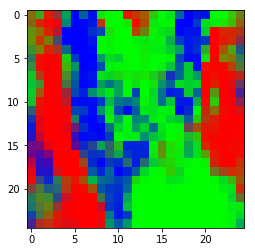

In [301]:
# Since output depth is of 3, we can directly plot as RGB Image
# R -> bg, G-> Cat, B-> Dog
# This might not be a good idea if num_class!=3
plt.imshow(predictions)

[182 284 159]


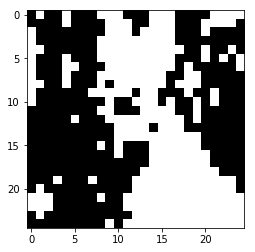

In [302]:
heatmap = np.argmax(predictions, axis=2)
bins = np.bincount(heatmap.astype(int).ravel())
print(bins)
label = np.argmax(bins)
# print(heatmap)
heatmap[heatmap != label] = 0
heatmap[heatmap == label] = 1
# print("Grid {} out of {} consists of cats...".format(n*n-np.sum(heatmap), n*n))
plt.imshow(heatmap, cmap='gray')

#### Slice Image

In [ ]:
res = []
for i in range(9):
    for j in range(9):
        p = predictions[i, j, :]
        res.append((i, j, p))
res

In [ ]:
res = []
for r in res:
    i, j = r[0], r[1]
    c = r[2][0]
    res_class.append((i, j, c))

In [ ]:
loc = np.argmax([r[2] for r in res_class])
loc

In [ ]:
c, r = loc//9, loc%9
(r, c)

#### Find original Location In Image

In [ ]:
## first let's do in grayscale
import skimage

In [ ]:
# timg = load_img(path, target_size=(256, 256)).convert('LA')
# plt.imshow(timg)
gimg = skimage.io.imread(path, as_grey=True)
plt.imshow(gimg, cmap='gray')

In [ ]:
gimg.shape

In [ ]:
gimg = skimage.transform.resize(gimg, (256, 256))

In [ ]:
gimg.shape

In [ ]:
gimg

In [ ]:
256//9

In [ ]:
r, c